Playing around with Health Nutrition and Population Statistics from World Bank, downloaded from Kaggle

In [1]:
# import the libraries

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import urllib.request 
import pdb
from sklearn import metrics, manifold
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA, PCA
from sklearn.preprocessing import StandardScaler
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper, ColorBar, LabelSet
from bokeh.palettes import Viridis, Category20
from bokeh.plotting import figure, show, output_notebook


In [2]:
# set filenames

datafile = '/Users/rmillin/Downloads/data.csv'
imgfile = '/Users/rmillin/Downloads/maptest.png'
shapefile = '/Users/rmillin/Downloads/ne_10m_admin_0_countries/ne_10m_admin_0_countries'
url = 'https://raw.githubusercontent.com/datasets/geo-boundaries-world-110m/master/countries.geojson'
testfile = urllib.request.URLopener()
testfile.retrieve(url, "countries.json")

('countries.json', <http.client.HTTPMessage at 0x1192562b0>)

In [3]:
# function for printing full dataframe
def print_full(x):
    a = x.shape
    pd.set_option('display.max_columns', a[0])
    print(x)
    pd.reset_option('display.max_columns')


In [4]:
# function for retrieving map data
def parse_map_data(geodata,statdata):

    geodata_features = geodata['features']
    country_xs = []
    country_ys = []
    country_names = []
    country_stats = []

    # get coordinates and name from map, data from dataframe
    # country names in the two lists don't match exactly, so define a match by one being contained within the other
    for aCountry in geodata_features:
        cName = aCountry['properties']['name']
        for anotherCountry in statdata.index:
            if (cName in anotherCountry) or (anotherCountry in cName):
                current_stat = statdata[statdata.index==anotherCountry][0]
                break
            else:
                current_stat = 0
        geometry_type = aCountry['geometry']['type']
        if geometry_type == "MultiPolygon":
            for poly_coords in aCountry['geometry']['coordinates']:
                coords = poly_coords[0]
                #tmp = map(lambda x:x[0],coords[0])
                country_xs.append(list(map(lambda x:x[0],coords)))
                country_ys.append(list(map(lambda x:x[1],coords)))
                country_names.append(cName)
                if not(math.isnan(current_stat)):
                    country_stats.append(current_stat)
                    #country_colors.append(colors[int(math.log(current_stat))])
                else:
                    country_stats.append(0)

        else:
            coords = aCountry['geometry']['coordinates'][0]
            country_xs.append(list(map(lambda x:x[0],coords)))
            country_ys.append(list(map(lambda x:x[1],coords)))
            country_names.append(cName)
            if not(math.isnan(current_stat)):
                country_stats.append(current_stat)
            else:
                country_stats.append(0)
                
    return country_xs, country_ys, country_names, country_stats


In [27]:
def mds_analysis(data,colors,labels,plottitle):
    # use the ICA data

    similarities = euclidean_distances(data)
    seed = np.random.RandomState(seed=3)

    mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                       dissimilarity="precomputed", n_jobs=1)
    pos = mds.fit(similarities).embedding_

    # Rescale the data
    pos *= np.sqrt((data ** 2).sum()) / np.sqrt((pos ** 2).sum())
    # Rotate the data
    clf = PCA(n_components=2)

    MDSdata = clf.fit_transform(pos)


    # plot it


    p = figure(tools=TOOLS, toolbar_location="above", logo="grey", plot_width=1200, title=plottitle)

    source = ColumnDataSource(
        data = dict(
            x=MDSdata[:,0],
            y=MDSdata[:,1],
            color=colors, # latest clustering result
            name=labels,
        )
    )

    #pdb.set_trace()

    p.circle("x", "y", size=12, source=source,
             color="color", line_color="black", fill_alpha=0.8)



    # instead of data points, show the country name in the cluster color
    labels = LabelSet(x="x", y="y", text="name",
                      text_font_size="8pt", text_color="#555555",
                      source=source, text_align='center')
    p.add_layout(labels)

    show(p)

In [5]:
# read in the data

df = pd.read_csv(datafile)


In [6]:


# take data only from 2015
data2015 = df.pivot(index='Country Name', columns='Indicator Name', values='2015')
#type(data2015.columns)
#print_full(data2015)
#print_full(data2015.columns)

# show what's in the data
# data2015.columns.values.tolist()

# get literacy data
litdata = data2015['Literacy rate, adult total (% of people ages 15 and above)']
# print(litdata)

#print(litdata)


In [7]:
# prep data for Bokeh


with open('countries.json','r') as f:
    geodata = json.load(f)

country_xs, country_ys, country_names, country_stats = parse_map_data(geodata,litdata)


country_colors = [Viridis[10][int(ind/10)] for ind in country_stats]

country_stats_text = country_stats
country_stats_text = list(map(lambda x:str(x),country_stats_text))
country_stats_text = list(map(lambda x:'no data available' if x=='0' else x, country_stats_text))


source = ColumnDataSource(
    data = dict(
        x=country_xs,
        y=country_ys,
        color=country_colors,
        name=country_names,
        rate=country_stats_text,
    )
)

output_notebook()

Loading BokehJS ...

In [8]:
# display on map


TOOLS="pan,wheel_zoom,box_zoom,reset,hover,save"
p = figure(title="World literacy rates", tools=TOOLS,
           x_axis_location=None, y_axis_location=None, plot_width=800, plot_height=500)
p.grid.grid_line_color = None
p.patches('x', 'y',
    fill_color='color', fill_alpha=0.7,
    line_color="black", line_width=0.5,
    source=source)

# make hover over info
country = data2015.index
hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Country", "@name"),
    ("Literacy rate (%)", "@rate"),
]

#pdb.set_trace()
# make colorbar
color_mapper = LinearColorMapper(palette=Viridis[10], low=0, high=100)
p.add_layout(ColorBar(color_mapper=color_mapper, location='bottom_left'))

# plt.savefig(imgfile, bbox_inches='tight', pad_inches=.2)
show(p)



Exploratory analysis:
Which countries are most similar as defined by these metrics?  Perhaps interventions that improve metrics for a given country will work well for countries with similar profiles.


In [9]:

# K-means clustering

nclusters = [4, 8, 16]
clusterdata = data2015.as_matrix()
datasz = clusterdata.shape
# find indicators that have entries for >90% of countries
prop_empty = np.sum(np.isnan(clusterdata),axis=0)/datasz[0]
keep = prop_empty<.1
kept_measures = data2015.columns[keep]
clusterdata = clusterdata[:,keep]
# eliminate countries with <90% of data
prop_empty = np.sum(np.isnan(clusterdata),axis=1)/datasz[1]
keep = prop_empty<.1
kept_countries = data2015.index[keep]
clusterdata = clusterdata[keep,:]

# replace missing measure values with population mean
measure_mean = np.nanmean(clusterdata,axis=0)
for col in range(len(kept_measures)):
    clusterdata[np.isnan(clusterdata[:,col]),col] = measure_mean[col]
    

# normalize data before clustering
clusterdata = StandardScaler().fit_transform(clusterdata)


#pdb.set_trace()


for clus in nclusters:
    country_stats = []
    cluster_result = KMeans(n_clusters=clus, init='k-means++', 
                           n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', 
                           verbose=0, random_state=None, copy_x=True, n_jobs=1, algorithm='auto').fit_predict(clusterdata)

    # put this into a pandas series since that's what my function is expecting and I'm too lazy to fix it
    cluster_result=pd.Series(data=cluster_result,index=kept_countries)  # 1st row as the column names

     
    # prepare for mapping
    country_xs, country_ys, country_names, country_stats = parse_map_data(geodata,cluster_result+1) # need to add 1 so countries with no data can be distinguished
    
    # map it
    country_colors = [Category20[clus+1][int(ind)] for ind in country_stats]

    country_stats_text = country_stats
    country_stats_text = list(map(lambda x:str(x),country_stats_text))
    country_stats_text = list(map(lambda x:'no data available' if x=='0' else x, country_stats_text))

    # make a list of all countries in each cluster; display the corresponding list whenever mousing over a country from a given cluster
    cluster_legend_list=[]
    for ind in range(len(country_stats)):
        clustern = country_stats[ind]
        cluster_list = []
        for countryind in range(len(country_names)):
            #pdb.set_trace()    
            if (country_stats[countryind]==clustern and 
                not(country_names[countryind] in cluster_list) and
                not(country_names[countryind]==country_names[ind])): # avoid duplicates
                cluster_list.append(country_names[countryind])
        cluster_legend_list.append('\n'.join(cluster_list))

    source = ColumnDataSource(
        data = dict(
            x=country_xs,
            y=country_ys,
            color=country_colors,
            name=country_names,
            cluster=country_stats_text,
            cluster_legend=cluster_legend_list
        )
    )

    output_notebook()
    p = figure(title="K-means, %d clusters" % clus, tools=TOOLS,
           x_axis_location=None, y_axis_location=None, plot_width=800, plot_height=500)
    p.grid.grid_line_color = None
    p.patches('x', 'y',
        fill_color='color', fill_alpha=0.7,
        line_color="black", line_width=0.5,
        source=source)

    # make hover over info
    hover = p.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
        
    hover.tooltips = [
        ("Country", "@name"),
        ("Clustered with", "@cluster_legend")
    ]

    # plt.savefig(imgfile, bbox_inches='tight', pad_inches=.2)
    show(p)

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Many indicators relate to population; results could be driven by population differences.  
Attempt to weight other themes more equally by reducing dimensionality.

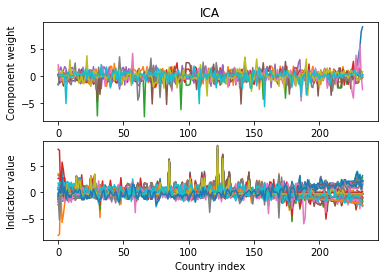

In [10]:

# perform ICA on the indicators to reduce the contribution from population measures to fewer components

n_components = 20
ICAdata = FastICA(n_components=10).fit_transform(clusterdata)
# normalize data before clustering
ICAdata = StandardScaler().fit_transform(ICAdata)

# plot original features, then components
# first sort by the first so redundancy is more evident
ICA_sorted = ICAdata[ICAdata[:,0].argsort()] # MAKE SURE THIS DOESN"T CHANGE ICAdata!!!
cluster_sorted = clusterdata[clusterdata[:,0].argsort()] # MAKE SURE THIS DOESN"T CHANGE clusterdata!!!

plt.subplot(2, 1, 1)
plt.plot(ICA_sorted)
plt.title('ICA')
plt.ylabel('Component weight')

plt.subplot(2, 1, 2)
plt.plot(cluster_sorted)
plt.xlabel('Country index')
plt.ylabel('Indicator value')

plt.show()

In [11]:
# go through the same clustering routine again

for clus in nclusters:
    country_stats = []
    cluster_result = KMeans(n_clusters=clus, init='k-means++', 
                           n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', 
                           verbose=0, random_state=None, copy_x=True, n_jobs=1, algorithm='auto').fit_predict(ICAdata)

    # put this into a pandas series since that's what my function is expecting and I'm too lazy to fix it
    cluster_result=pd.Series(data=cluster_result,index=kept_countries)  

     
    # prepare for mapping
    country_xs, country_ys, country_names, country_stats = parse_map_data(geodata,cluster_result+1) # need to add 1 so countries with no data can be distinguished
    
    # map it
    country_colors = [Category20[clus+1][int(ind)] for ind in country_stats]

    country_stats_text = country_stats
    country_stats_text = list(map(lambda x:str(x),country_stats_text))
    country_stats_text = list(map(lambda x:'no data available' if x=='0' else x, country_stats_text))

    # make a list of all countries in each cluster; display the corresponding list whenever mousing over a country from a given cluster
    cluster_legend_list=[]
    for ind in range(len(country_stats)):
        clustern = country_stats[ind]
        cluster_list = []
        for countryind in range(len(country_names)):
            #pdb.set_trace()    
            if (country_stats[countryind]==clustern and 
                not(country_names[countryind] in cluster_list) and
                not(country_names[countryind]==country_names[ind])): # avoid duplicates
                cluster_list.append(country_names[countryind])
        cluster_legend_list.append('\n'.join(cluster_list))

    source = ColumnDataSource(
        data = dict(
            x=country_xs,
            y=country_ys,
            color=country_colors,
            name=country_names,
            cluster=country_stats_text,
            cluster_legend = cluster_legend_list
        )
    )

    output_notebook()
    p = figure(title="K-means, %d clusters" % clus, tools=TOOLS,
           x_axis_location=None, y_axis_location=None, plot_width=800, plot_height=500)
    p.grid.grid_line_color = None
    p.patches('x', 'y',
        fill_color='color', fill_alpha=0.7,
        line_color="black", line_width=0.5,
        source=source)

    # make hover over info
    hover = p.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
    hover.tooltips = [
        ("Country", "@name"),
        ("Clustered with", "@cluster_legend")
    ]

    # plt.savefig(imgfile, bbox_inches='tight', pad_inches=.2)
    show(p)

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Use multidimensional scaling to instead visualize country similarity in a 2d space

In [28]:
# use the ICA data

country_colors = [Category20[clus+1][int(ind)+1] for ind in cluster_result]
country_names = kept_countries.tolist()
mds_analysis(ICAdata,country_colors,country_names,'Multi-dimensional scaling, after ICA')

Replot map, with mouseover showing 3 most similar countries in reduced feature space

In [ ]:
# calculate feature distance between countries

similarities = euclidean_distances(data)








p = figure(title="K-means, %d clusters" % clus, tools=TOOLS,
       x_axis_location=None, y_axis_location=None, plot_width=800, plot_height=500)
p.grid.grid_line_color = None
p.patches('x', 'y',
    fill_color='color', fill_alpha=0.7,
    line_color="black", line_width=0.5,
    source=source)

# make hover over info
hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Country", "@name"),
    ("Most similar to", "@cluster_legend")
]

# plt.savefig(imgfile, bbox_inches='tight', pad_inches=.2)
show(p)